# Calculation of detectable Gamma ray burst (GRB) event rate associated with Binary Neutron Star (BNS) mergers.

Analyst: [Hemanta Ph.](https://hemantaph.notion.site/Hemanta-Ph-b4c52e857d424c0db2a68f4e63d6097f), Anupreeta More, Otto Hannuksela.

Notes:

* This is without considering a particular detectors' sensitivity, but rather a general calculation of the rate of detectable GRBs based of viewing angle and luminosity distance. I have considered the inclination angle gravitational waves same as the viewing angle wrt GRB jet axis.

* It involves constructing Pdet (detection probability) function based off luminosity function.

* For BNS source redshift and mass distribution, refer [here](https://ler.readthedocs.io/en/latest/GW_events.html).

* For lens and image properties, refer [here](https://ler.readthedocs.io/en/latest/Lensed_events.html).

* Both SWIFT and FERMI detectors are considered.

* All analysis will be limited to redshift $z\in [0,5]$.

### Combined plot of viewing angle vs redshift for both conditions (left: Codition1, right: Condition2).

<p align="center">
  <img src="./combined final.png" alt="Your Logo" width="200%" style="margin: 0; padding: 0;">
</p>

## Equations (GRB)

* Ref: [Howell et. al. (2019)](https://arxiv.org/pdf/1811.09168)

* The luminosity function of GRBs is given by:

$$L(\theta_{V})=L_{c}\text{exp}(-\frac{\theta^{2}}{2\theta_{c}^{2}})$$

* Here, $L(\theta_{V})$ is the luminosity at viewing angle $\theta_{V}$, $L_{c}$ is the luminosity at the jet axis, $\theta$ is the viewing angle, and $\theta_{c}$ is the core angle of the jet.

* The paper gives: $\theta_{c} = 5$ degree.

* I will infer the probability of detection from the above equations.

$$P_{det}(\theta,D_L) = \left\{ 
  \begin{array}{ c l }
    1 & \text{if } \theta \le 5 \text{ deg and } D_L \le 46652 \text{ Mpc } (z\sim 5) \\
    1 & \text{if } \frac{\text{a}}{4\pi D_L^2} \text{exp}(-\frac{\theta^{2}}{2\times 21.2^2}) \ge 1 \\
    0 & \text{otherwise}
  \end{array}
\right.$$

* Coefficients a is solved by considering conditions 2 below,
  1. If angle <= 5 deg, distance <= distance_cut, then $P_{det}$ = 1.
  2. pdet=1, If angle=21.2 deg (at distance=40Mpc). This is by considering the GRB from GW170817 would have been difficult to detect if viewing angle>21.2 deg (at distance=40Mpc) or distance>40 Mpc (at angle=21.2 deg).

In [1]:
# calling the necessary libraries
from ler.rates import LeR
import numpy as np
# interpolate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from ler.utils import get_param_from_json

## Probability of detection of GRBs

### Finding the coefficients

In [2]:
import numpy as np
from scipy.optimize import fsolve

# to find coefficient a
# consider: pdet = 1, If angle = 21.2 deg (at distance=40). 
def equation(a):
    angle = 21.2
    distance = 40
    return a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2) - 1

a_guess = 10000

# Solve the equation
a_solution = fsolve(equation, a_guess)

print(f"a = {a_solution[0]}")

a = 161107621.34601912


### Function to calculate the probability of detection

In [3]:
# Find distance_cut
# convert redshift to luminoisty distance
import astropy.units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
# let's assume z = 5 is the distance cut
z = 5
d_L = cosmo.luminosity_distance(z)
print(f"d_L = {d_L}")

d_L = 46652.22297277719 Mpc


In [4]:
class GRB:
    def __init__(self,
    z_min = 0, # minimum redshift
    z_max = 10, # maximum redshift 
    core_angle = 5, # core angle in degrees
    distance_cut = 46652.22297277721, # distance cut in Mpc for z=5
    cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7), # cosmology
    ):
        self.core_angle = core_angle
        self.distance_cut = distance_cut
        self.cosmo = cosmo
        self.coefficient = self.coefficient_finder()

        # interpolate and find luminosity distance to redshift conversion
        z = np.geomspace(z_min+0.0001, z_max, 10000)
        d_L = cosmo.luminosity_distance(z).value
        self.z_to_dl = interp1d(z, d_L, kind='cubic', fill_value='extrapolate')
        self.dl_to_z = interp1d(d_L, z, kind='cubic', fill_value='extrapolate')

    def coefficient_finder(self, a_guess = 10000):
        """
        Function to find the coefficient 'a' in the GRB pdet model.
        pdet = a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2){2\times 21.2^2})
        pdet = 1, If angle = 21.2 deg (at distance=40).

        Parameters
        ----------
        a_guess : float
            Initial guess for the coefficient 'a'
            default is 10000

        Returns
        -------
        float
            Coefficient 'a' in the GRB pdet model
        """
        def equation(a):
            # wrt to GW170817
            angle = 21.2
            distance = 40
            return a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2) - 1

        a_solution = fsolve(equation, a_guess)
        return a_solution[0]
    
    def pdet_grb(self, angle, distance, distance_cut=None, duty_cycle=0.5, mask_duty_cycle=True, bool=True, pdet_cut=1.):
        """
        Function to calculate the probability of detection for a given angle and distance (Mpc) for GRB. 

        Parameters
        ----------
        angle : numpy.ndarray
            Angle between the GRB jet and viewing angle in (rad)
        distance : numpy.ndarray
            Distance between the GRB source and the satellite in (Mpc)
        distance_cut : float
            Core angular size of the GRB jet in (rad)
            default is 25422.742 Mpc
        duty_cycle : float
            Duty cycle of detector(s)
            default is 0.5 (50%: for Fermi-GBM and Swift-BAT combined)
        bool : bool
            if True, return absolute value of pdet
            if False, return the pdet value as boolean (with duty cycle applied)

        Returns
        -------
        numpy.ndarray
            Probability of detection for a given angle and distance
        """

        a = self.coefficient
        jet_angle_cut = self.core_angle
        if distance_cut is None:
            distance_cut = self.distance_cut

        # make sure that the input data is a numpy array
        angle, distance = np.array([angle]).reshape(-1), np.array([distance]).reshape(-1)

        # angle should be less than 90 or equal to 90
        if len(angle[angle > 90]) > 0:
            angle[angle > 90] = angle[angle > 90]%90

        if bool:
            # calculate the probability of detection, absolute value
            pdet = abs(a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/jet_angle_cut)**2))

            # find idx of angle <= jet_angle_cut and distance <= distance_cut
            idx = (angle <= jet_angle_cut) & (distance <= distance_cut)
            # apply the condition, condition 1 from docstring
            pdet[idx] = 1

            # apply the duty cycle
            if mask_duty_cycle:
                # sample random numbers from 0 to 1 and check if it is less than the duty cycle
                num_ = np.random.rand(len(angle))
                mask_duty_cycle = num_ > duty_cycle
                pdet[mask_duty_cycle] = 0

            # return the pdet as boolean
            return (pdet>=pdet_cut).astype(int)
        else:
            # return the probability of detection (absolute value)
            return abs(a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/jet_angle_cut)**2))
    
    def pdet_calculator(self, gw_param_dict, duty_cycle=0.5, mask_duty_cycle=True, bool=True, pdet_cut=1.):
        """
        Pdet calculator for GRB. The  inputs and outputs are are compatible with ler package.

        Parameters
        ----------
        gw_param_dict : dict
            dictionary containing the parameters for the GW event
        duty_cycle : float
            Duty cycle of detector(s)
            default is 0.5 (50%: for Fermi-GBM and Swift-BAT combined)
        mask_duty_cycle : bool
            if True, apply the duty cycle
            default is True
        bool : bool
            if True, return absolute value of pdet
            if False, return the pdet value as boolean (with duty cycle applied)

        Returns
        -------
        dict
            dictionary containing the probability of detection for the given GW event
        """

        # get the angle and distance from the dictionary
        angle = np.degrees(gw_param_dict['theta_jn'])
        if 'luminosity_distance' in gw_param_dict:
            distance = gw_param_dict['luminosity_distance']
        elif 'effective_luminosity_distance' in gw_param_dict:
            distance = gw_param_dict['effective_luminosity_distance']

        # calculate the probability of detection
        pdet = self.pdet_grb(angle, distance, duty_cycle=duty_cycle, mask_duty_cycle=mask_duty_cycle, bool=bool, pdet_cut=pdet_cut)
        pdet_net_dict = dict(pdet_net=pdet)

        # return the pdet
        return pdet_net_dict

In [5]:
# class initialization
grb = GRB()

In [6]:
# test the pdet_grb function
angle = np.array([1, 1, 20, 90])
distance = np.array([46652, 46653, 40, 40])
print(grb.pdet_grb(angle, distance, mask_duty_cycle=False, bool=True))

[1 0 1 0]


In [7]:
# test the pdet_calculator function
gw_param_dict = {'theta_jn': np.radians(np.array([1, 21.2, 90])), 'luminosity_distance': np.array([2500, 40, 40])}
print(grb.pdet_calculator(gw_param_dict, mask_duty_cycle=False, bool=True))

{'pdet_net': array([1, 1, 0])}


### Plot detection and non-detection regions

In [8]:
# generate random data
angle = np.random.uniform(0, 30, 5000)
log10_distance = np.random.uniform(0, 5, 5000)
distance = 10**log10_distance
redshift = grb.dl_to_z(distance)

pdet = grb.pdet_grb(angle, distance, mask_duty_cycle=False, bool=True)

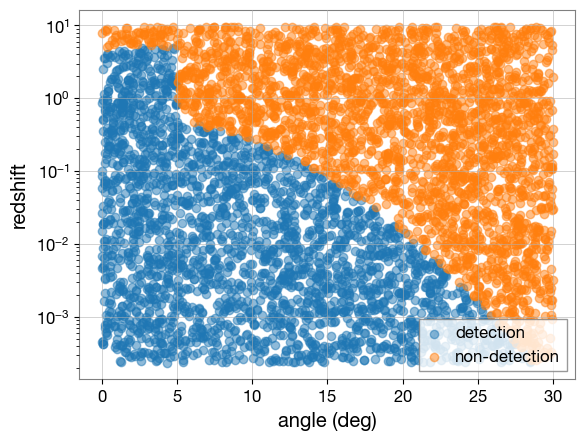

In [9]:
# blue: detection, red: non-detection
plt.scatter(angle[pdet==1], redshift[pdet==1], c='C0', label="detection", alpha=0.5)
plt.scatter(angle[pdet==0], redshift[pdet==0], c='C1', label="non-detection", alpha=0.5)

# draw a horizontal line for GW170817, 40Mpc
# plt.hlines(y=grb.dl_to_z(40), xmin=min(angle)-1, xmax=max(angle)+1, colors='C3', linestyles='solid', label='40Mpc, GW170817')

plt.xlabel("angle (deg)")
plt.ylabel("redshift")
plt.yscale("log")
plt.legend()
plt.grid(alpha=0.8)
plt.show()

## Rate calculation of GRB with LeR

All the necessary functions and parameters are defined below.

**Source related:**
* source frame mass: m1 and m2 sample from [double Gaussian](https://ler.readthedocs.io/en/latest/GW_events.html#BNS-mass-distribution:-Bimodal-Gaussian-Model) model lim[1,2.3]Mo
* Geocent time period: uniform prior, 1 year GPS: {'min_': 1238166018, 'max_': 1269702018}
* Redshift: 0 to 5, uniform, 
  * this follows [merger rate density distribution](https://ler.readthedocs.io/en/latest/GW_events.html#Merger-Rate-Density-Formula)
* ra:  sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}
* dec:  sampler_cosine [-np.pi/2, np.pi/2]
* phase : sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}
* psi: sampler_uniform {'min_': 0.0, 'max_': 3.141592653589793}
* theta_jn: sampler_uniform {'min_': 0.0, 'max_': 3.141592653589793}

**Lens related**
* Optical depth: SIE , 
  * so zs for lensed are rejection sampled with optical depth. 
* Lens redshifts: SDSS catalogue (0 to zs), the function of zs Reenske et al. 2021 ( eqnC13). [`ler` function](https://github.com/hemantaph/ler/blob/bce3330638a13ee0883d19633abb17b98791c901/ler/lens_galaxy_population/jit_functions.py#L218)
* Velocity dispersion: gengamma, Haris et al 2018, a=2.32 / 2.67, c=2.67, vd_min=0., vd_max=600.(https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gengamma.html) use in Haris et al upto zs~1.5 (with a=2.32 / 2.67, c=2.67)
* Axis ratio: Raleigh (with Velocity dispersion dependence) {'q_min': 0.2, 'q_max': 1.0}
* axis_rotation_angle : uniform {'phi_min': 0.0, 'phi_max': 6.283185307179586}
* shear: normal {'scale': 0.05}
* density_profile_slope: normal {'mean': 2.0, 'std': 0.2}

**Image related:**
* Strong lensing condition: num_images>=2
* Lens equation solver: EPL+Shear, `lenstronomy`
* Source position: sample within caustic,  Ewoud et. al. 2022

## MEDIAN

In [10]:
ler = LeR(
    npool=4,
    verbose=False,
    z_max=10,
    pdet_finder=grb.pdet_calculator,
    source_priors= {'merger_rate_density': 'sfr_madau_dickinson2014'},
    source_priors_params= {'merger_rate_density': dict(a=105.5 * 1e-9, b=2.6, c=3.2, d=6.2)}, # sfr_madau_fragos2017
    event_type='BNS',
    mtot_min=2.0,
    mtot_max=51,
    psds={'L1':'../rates_o4/o4_psd.txt', 'H1':'../rates_o4/o4_psd.txt'},
    snr_type="interpolation",
)


Initializing LeR class...



### Unlensed events

In [11]:
unlensed_param_detectable = ler.selecting_n_unlensed_detectable_events(
    size=100000,
    batch_size=200000,
    resume=False,
    trim_to_size=False,
    detectability_condition="pdet",
    output_jsonfile="n_unlensed_params_detectable_grb_median.json",
    meta_data_file="meta_unlensed_grb_median.json",
)
# time: 3 min 30 s

removing ./ler_data/n_unlensed_params_detectable_grb_median.json and ./ler_data/meta_unlensed_grb_median.json if they exist
collected number of detectable events =  0
collected number of detectable events =  4334
total number of events =  200000
total rate (yr^-1): 10189.850192862
collected number of detectable events =  8506
total number of events =  400000
total rate (yr^-1): 9999.407676567165
collected number of detectable events =  12744
total number of events =  600000
total rate (yr^-1): 9987.651965684767
collected number of detectable events =  16922
total number of events =  800000
total rate (yr^-1): 9946.506977596377
collected number of detectable events =  21197
total number of events =  1000000
total rate (yr^-1): 9967.432142967044
percentage difference for the last 4 batches = [0.32080011 0.2028589  0.20993537 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage'] o

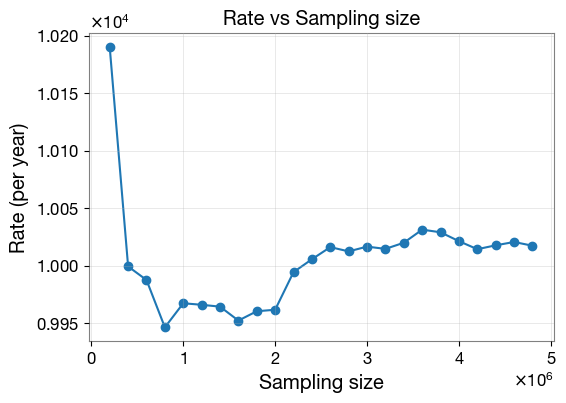

In [12]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_unlensed_grb_median.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [13]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 4e6)[0]
# take average 
grb_rate_unlensed_median = np.mean(meta_data['total_rate'][idx])
print('Unlensed GRB Rate (per year) =', grb_rate_unlensed_median)

Unlensed GRB Rate (per year) = 10017.575704016988


### Lensed events

In [14]:
lensed_param_detectable = ler.selecting_n_lensed_detectable_events(
    size=10000,
    batch_size=50000,
    # snr_threshold=[8.0,8.0],
    # num_img=[1,1],
    resume=False,
    trim_to_size=True,
    detectability_condition="pdet",
    output_jsonfile="n_lensed_params_detectable_grb_median.json",
    meta_data_file="meta_lensed_grb_median.json",
)

removing ./ler_data/n_lensed_params_detectable_grb_median.json and ./ler_data/meta_lensed_grb_median.json if they exist
collected number of detectable events =  0


  0%|                                                           | 80/50000 [00:00<01:02, 792.90it/s]

collected number of detectable events =  324
total number of events =  50000
total rate (yr^-1): 3.647096258198826


  0%|                                                           | 82/50000 [00:00<01:01, 816.56it/s]

collected number of detectable events =  635
total number of events =  100000
total rate (yr^-1): 3.573929203636195


  0%|                                                           | 81/50000 [00:00<01:02, 802.04it/s]

collected number of detectable events =  965
total number of events =  150000
total rate (yr^-1): 3.6208311616891637


  0%|                                                           | 82/50000 [00:00<01:00, 819.26it/s]

collected number of detectable events =  1290
total number of events =  200000
total rate (yr^-1): 3.630211553299757


  0%|                                                           | 82/50000 [00:00<01:01, 815.96it/s]

collected number of detectable events =  1594
total number of events =  250000
total rate (yr^-1): 3.5885626145487213
percentage difference for the last 4 batches = [0.40777917 0.89920535 1.16060226 0.        ]


  0%|                                                           | 84/50000 [00:00<00:59, 832.33it/s]

collected number of detectable events =  1902
total number of events =  300000
total rate (yr^-1): 3.5683009686698393
percentage difference for the last 4 batches = [1.4721346  1.73501577 0.56782334 0.        ]


  0%|                                                           | 27/50000 [00:00<03:19, 250.60it/s]

collected number of detectable events =  2225
total number of events =  350000
total rate (yr^-1): 3.5779493714693067
percentage difference for the last 4 batches = [1.46067416 0.29662921 0.26966292 0.        ]


  0%|                                                           | 81/50000 [00:00<01:01, 806.11it/s]

collected number of detectable events =  2556
total number of events =  400000
total rate (yr^-1): 3.59644214350162
percentage difference for the last 4 batches = [0.21909233 0.78247261 0.51419629 0.        ]


  0%|                                                           | 80/50000 [00:00<01:02, 798.46it/s]

collected number of detectable events =  2876
total number of events =  450000
total rate (yr^-1): 3.5970675029423265
percentage difference for the last 4 batches = [0.79972184 0.53149215 0.01738526 0.        ]


  0%|                                                           | 82/50000 [00:00<01:01, 811.14it/s]

collected number of detectable events =  3188
total number of events =  500000
total rate (yr^-1): 3.5885626145487213
percentage difference for the last 4 batches = [0.29575193 0.2195734  0.23699986 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


  0%|                                                           | 82/50000 [00:00<01:01, 812.47it/s]

collected number of detectable events =  3523
total number of events =  550000
total rate (yr^-1): 3.605140324813261
percentage difference for the last 4 batches = [0.24127164 0.22392532 0.45983537 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


  0%|                                                           | 82/50000 [00:00<01:01, 816.21it/s]

collected number of detectable events =  3874
total number of events =  600000
total rate (yr^-1): 3.6339637099439948
percentage difference for the last 4 batches = [1.01531578 1.24935467 0.79316656 0.        ]


  0%|                                                           | 82/50000 [00:00<01:01, 812.35it/s]

collected number of detectable events =  4210
total number of events =  650000
total rate (yr^-1): 3.6453644935937928
percentage difference for the last 4 batches = [1.55819477 1.10343338 0.31274743 0.        ]


  0%|                                                           | 82/50000 [00:00<01:01, 814.03it/s]

collected number of detectable events =  4527
total number of events =  700000
total rate (yr^-1): 3.6398599560992246
percentage difference for the last 4 batches = [0.95387272 0.16199102 0.15122938 0.        ]


  0%|                                                           | 82/50000 [00:00<01:01, 817.16it/s]

collected number of detectable events =  4880
total number of events =  750000
total rate (yr^-1): 3.662104884775776
percentage difference for the last 4 batches = [0.76844262 0.45712484 0.6074356  0.        ]


  0%|                                                           | 81/50000 [00:00<01:02, 804.74it/s]

collected number of detectable events =  5218
total number of events =  800000
total rate (yr^-1): 3.67101625680584
percentage difference for the last 4 batches = [0.69876463 0.84871051 0.24274946 0.        ]


  0%|                                                           | 79/50000 [00:00<01:03, 789.20it/s]

collected number of detectable events =  5566
total number of events =  850000
total rate (yr^-1): 3.68550068502808
percentage difference for the last 4 batches = [1.23838612 0.63480656 0.39301114 0.        ]


  0%|                                                           | 82/50000 [00:00<01:01, 817.70it/s]

collected number of detectable events =  5906
total number of events =  900000
total rate (yr^-1): 3.693372856811088
percentage difference for the last 4 batches = [0.84659668 0.60531663 0.21314316 0.        ]


  0%|                                                           | 80/50000 [00:00<01:03, 791.70it/s]

collected number of detectable events =  6253
total number of events =  950000
total rate (yr^-1): 3.7045634994342524
percentage difference for the last 4 batches = [0.90556533 0.51457653 0.30207723 0.        ]


  0%|                                                           | 82/50000 [00:00<01:01, 815.45it/s]

collected number of detectable events =  6590
total number of events =  1000000
total rate (yr^-1): 3.709006842828744
percentage difference for the last 4 batches = [0.63375881 0.42151408 0.11979874 0.        ]


  0%|                                                           | 82/50000 [00:00<01:01, 815.46it/s]

collected number of detectable events =  6924
total number of events =  1050000
total rate (yr^-1): 3.711418943528611
percentage difference for the last 4 batches = [0.48623147 0.18471221 0.06499133 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


  0%|                                                           | 81/50000 [00:00<01:01, 807.45it/s]

collected number of detectable events =  7243
total number of events =  1100000
total rate (yr^-1): 3.705936896483459
percentage difference for the last 4 batches = [0.03705937 0.0828386  0.14792608 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


  0%|                                                           | 81/50000 [00:00<01:02, 801.03it/s]

collected number of detectable events =  7557
total number of events =  1150000
total rate (yr^-1): 3.6984844905003387
percentage difference for the last 4 batches = [0.28450443 0.34972306 0.20149891 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


  0%|                                                           | 82/50000 [00:00<01:01, 812.89it/s]

collected number of detectable events =  7897
total number of events =  1200000
total rate (yr^-1): 3.7038476274429177
percentage difference for the last 4 batches = [0.20441759 0.05640807 0.14479907 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


  0%|                                                           | 81/50000 [00:00<01:02, 804.98it/s]

collected number of detectable events =  8198
total number of events =  1250000
total rate (yr^-1): 3.691221620335059
percentage difference for the last 4 batches = [0.39865599 0.19676061 0.34205497 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


  0%|                                                           | 78/50000 [00:00<01:04, 777.77it/s]

collected number of detectable events =  8515
total number of events =  1300000
total rate (yr^-1): 3.6864939029633197
percentage difference for the last 4 batches = [0.32525722 0.47073791 0.12824427 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


  0%|                                                           | 80/50000 [00:00<01:02, 793.76it/s]

collected number of detectable events =  8875
total number of events =  1350000
total rate (yr^-1): 3.7000433575119547
percentage difference for the last 4 batches = [0.1028169  0.23842254 0.36619718 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


  0%|                                                           | 82/50000 [00:00<01:01, 814.38it/s]

collected number of detectable events =  9215
total number of events =  1400000
total rate (yr^-1): 3.704584658212321
percentage difference for the last 4 batches = [0.36071622 0.48833424 0.12258596 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


  0%|                                                           | 83/50000 [00:00<01:00, 820.33it/s]

collected number of detectable events =  9550
total number of events =  1450000
total rate (yr^-1): 3.706871995082885
percentage difference for the last 4 batches = [0.54973822 0.18421563 0.06170531 0.        ]


  0%|                                                           | 79/50000 [00:00<01:03, 780.95it/s]

collected number of detectable events =  9895
total number of events =  1500000
total rate (yr^-1): 3.712758999472982
percentage difference for the last 4 batches = [0.34248498 0.22016892 0.15856145 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.02it/s]


collected number of detectable events =  10240
total number of events =  1550000
total rate (yr^-1): 3.7182661971282336
percentage difference for the last 4 batches = [0.3679548  0.30643858 0.14811198 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']
Given size=10000 reached
storing detectable lensed params in ./ler_data/n_lensed_params_detectable_grb_median.json
storing meta data in ./ler_data/meta_lensed_grb_median.json

 trmming final result to size=10000
collected number of detectable events =  10000
total number of events =  1513672.0
total lensed event rate (yr^-1): 3.718265890071437


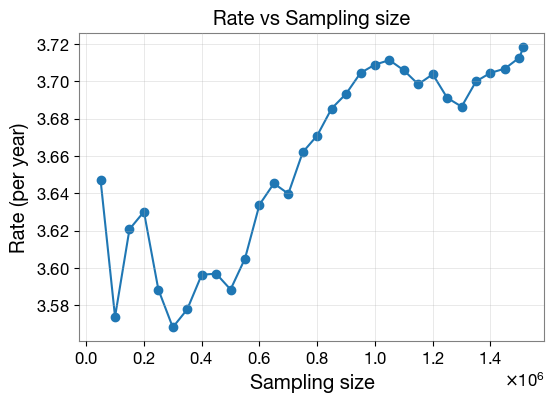

In [17]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_lensed_grb_median.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [18]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 0.5e6)[0]
# take average 
grb_rate_lensed_median = np.mean(meta_data['total_rate'][idx])
print('Lensed GRB Rate (per year) =', grb_rate_lensed_median)

Lensed GRB Rate (per year) = 3.68522961389235


In [19]:
grb_rate_unlensed_median/grb_rate_lensed_median, grb_rate_unlensed_median, grb_rate_lensed_median

(2718.3043537513518, 10017.575704016988, 3.68522961389235)

In [21]:
from ler.utils import get_param_from_json
import numpy as np

lens_param_n = get_param_from_json('ler_data/n_lensed_params_detectable_grb_median.json')

In [22]:
# 4 images
# add accross all images
snr = lens_param_n['pdet_net']==1.
mu = ~np.isnan(lens_param_n['magnifications'])
type = lens_param_n['image_type']

# add accross all images
num_ = np.sum(mu, axis=1)
# select only 4 images
idx = num_ == 4
# get time information
dt_eff = lens_param_n['effective_geocent_time'][idx]
snr = lens_param_n['pdet_net'][idx]

dt_4images_10 = []
dt_4images_20 = []
dt_4images_30 = []
dt_4images_21 = []
dt_4images_31 = []
dt_4images_32 = []
dt_4images = []
for i, dt in enumerate(dt_eff):
    # image 1,0
    if snr[i, 1] == 1. and snr[i, 0] == 1.:
        dt_4images_10.append(abs(dt[1]-dt[0]))
    # image 2,0
    if snr[i, 2] == 1. and snr[i, 0] == 1.:
        dt_4images_20.append(abs(dt[2]-dt[0]))
    # image 3,0
    if snr[i, 3] == 1. and snr[i, 0] == 1.:
        dt_4images_30.append(abs(dt[3]-dt[0]))
    # image 2,1
    if snr[i, 2] == 1. and snr[i, 1]== 1.:
        dt_4images_21.append(abs(dt[2]-dt[1]))
    # image 3,1
    if snr[i, 3] == 1. and snr[i, 1]== 1.:
        dt_4images_31.append(abs(dt[3]-dt[1]))
    # image 3,2
    if snr[i, 3] == 1. and snr[i, 2]== 1.:
        dt_4images_32.append(abs(dt[3]-dt[2]))

dt_4images_10 = np.array(dt_4images_10)/(60)
dt_4images_20 = np.array(dt_4images_20)/(60)
dt_4images_30 = np.array(dt_4images_30)/(60)
dt_4images_21 = np.array(dt_4images_21)/(60)
dt_4images_31 = np.array(dt_4images_31)/(60)
dt_4images_32 = np.array(dt_4images_32)/(60)
dt_4images = np.concatenate([dt_4images_10, dt_4images_20, dt_4images_30, dt_4images_21, dt_4images_31, dt_4images_32])

In [23]:
# 1,0: 13:56:05.77-13:09:02.03
# 2,1: 14:49:31.91-13:56:05.77
# 3,2: 16:21:33.07-14:49:31.91

dt_10 = 13*60*60 + 56*60 + 5.77 - (13*60*60 + 9*60 + 2.03)
dt_21 = 14*60*60 + 49*60 + 31.91 - (13*60*60 + 56*60 + 5.77)
dt_32 = 16*60*60 + 21*60 + 33.07 - (14*60*60 + 49*60 + 31.91)
print(f"dt_10 = {dt_10/60} mins")
print(f"dt_21 = {dt_21/60} mins")
print(f"dt_32 = {dt_32/60} mins")

dt_10 = 47.0623333333333 mins
dt_21 = 53.435666666666776 mins
dt_32 = 92.01933333333326 mins


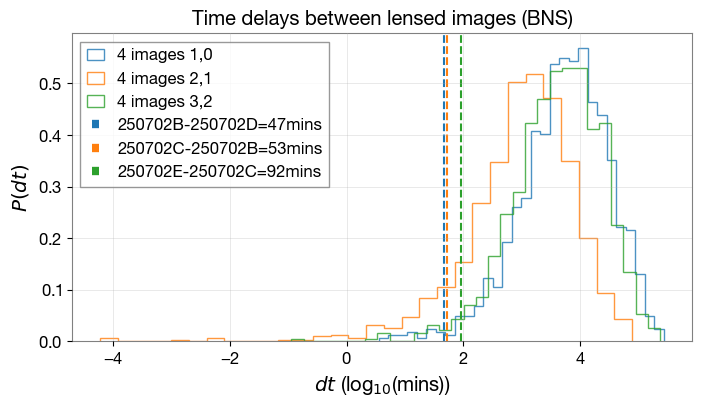

In [24]:
import numpy as np
import matplotlib.pyplot as plt
# plot histogram
plt.figure(figsize=(8, 4))
plt.hist(np.log10(dt_4images_10), bins=30, alpha=0.8, density=True, histtype='step', color='C0', label='4 images 1,0')
plt.hist(np.log10(dt_4images_21), bins=30, alpha=0.8, density=True, histtype='step', color='C1', label='4 images 2,1') 
plt.hist(np.log10(dt_4images_32), bins=30, alpha=0.8, density=True, histtype='step', color='C2', label='4 images 3,2')

plt.axvline(np.log10(dt_10/60), color='C0', linestyle='--', label='250702B-250702D=47mins')
plt.axvline(np.log10(dt_21/60), color='C1', linestyle='--', label='250702C-250702B=53mins')
plt.axvline(np.log10(dt_32/60), color='C2', linestyle='--', label='250702E-250702C=92mins')

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel(r'$dt$ (log$_{10}$(mins))')
plt.ylabel(r'$P(dt)$')
plt.title('Time delays between lensed images (BNS)')
plt.show()

In [27]:
# 3 images
# add accross all images
snr = lens_param_n['pdet_net'] == 1.
mu = ~np.isnan(lens_param_n['magnifications'])
type = lens_param_n['image_type']

# add accross all images
num_ = np.sum(mu, axis=1)
# select only 3 images
idx = num_ == 3

# get time information
dt_eff = lens_param_n['effective_geocent_time'][idx]
snr = lens_param_n['pdet_net'][idx]

dt_3images_10 = []
dt_3images_20 = []
dt_3images_21 = []
dt_3images = []
for i, dt in enumerate(dt_eff):
    # image 1,0
    if snr[i, 1] == 1. and snr[i, 0] == 1.:
        dt_3images_10.append(abs(dt[1]-dt[0]))
    # image 2,0
    if snr[i, 2] == 1. and snr[i, 0] == 1.:
        dt_3images_20.append(abs(dt[2]-dt[0]))
    # image 2,1
    if snr[i, 2] == 1. and snr[i, 1]== 1.:
        dt_3images_21.append(abs(dt[2]-dt[1]))

dt_3images_10 = np.array(dt_3images_10)/(60)
dt_3images_20 = np.array(dt_3images_20)/(60)
dt_3images_21 = np.array(dt_3images_21)/(60)
dt_3images = np.concatenate([dt_3images_10, dt_3images_20, dt_3images_21])

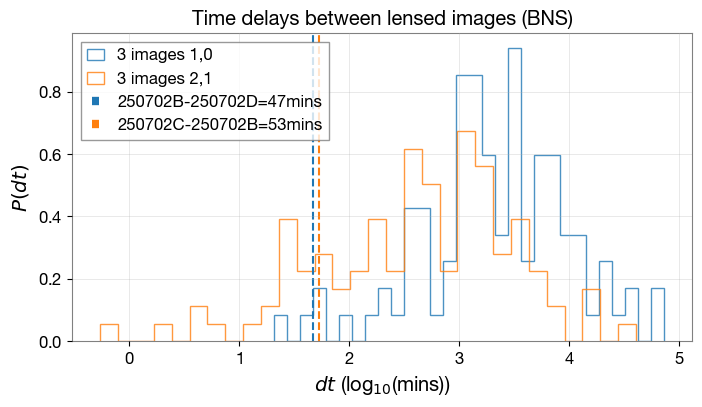

In [40]:
import numpy as np
import matplotlib.pyplot as plt
# plot histogram
plt.figure(figsize=(8, 4))
plt.hist(np.log10(dt_3images_10), bins=30, alpha=0.8, density=True, histtype='step', color='C0', label='3 images 1,0')
plt.hist(np.log10(dt_3images_21), bins=30, alpha=0.8, density=True, histtype='step', color='C1', label='3 images 2,1')
plt.axvline(np.log10(dt_10/60), color='C0', linestyle='--', label='250702B-250702D=47mins')
plt.axvline(np.log10(dt_21/60), color='C1', linestyle='--', label='250702C-250702B=53mins')
# plt.axvline(np.log10(dt_32/60), color='C2', linestyle='--', label='250702E-250702C=92mins') 

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel(r'$dt$ (log$_{10}$(mins))')
plt.ylabel(r'$P(dt)$')
plt.title('Time delays between lensed images (BNS)')
plt.show()
    

In [41]:
# 2 images
# add accross all images
snr = lens_param_n['pdet_net'] == 1.
mu = ~np.isnan(lens_param_n['magnifications'])
type = lens_param_n['image_type']

# add accross all images
num_ = np.sum(mu, axis=1)
# select only 2 images
idx = num_ == 2

# get time information
dt_eff = lens_param_n['effective_geocent_time'][idx]
snr = lens_param_n['pdet_net'][idx]

dt_2images = []
for i, dt in enumerate(dt_eff):
    # image 1,2
    if snr[i, 0] == 1. and snr[i, 1] == 1.:
        dt_2images.append(abs(dt[1]-dt[0]))
dt_2images = np.array(dt_2images)/(24*3600)
        

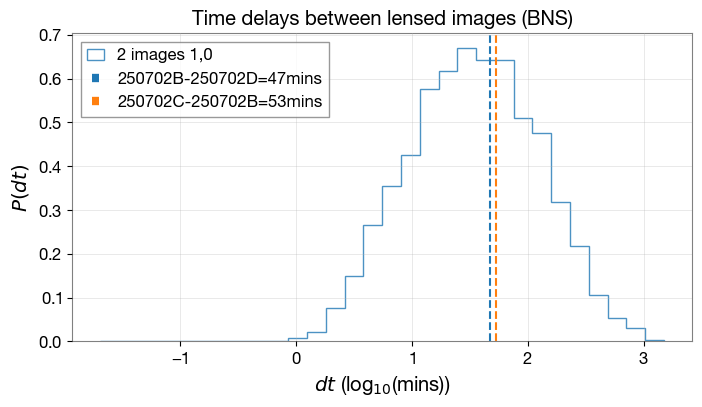

In [42]:
import numpy as np
import matplotlib.pyplot as plt
# plot histogram
plt.figure(figsize=(8, 4))
plt.hist(np.log10(dt_2images), bins=30, alpha=0.8, density=True, histtype='step', color='C0', label='2 images 1,0')
plt.axvline(np.log10(dt_10/60), color='C0', linestyle='--', label='250702B-250702D=47mins')
plt.axvline(np.log10(dt_21/60), color='C1', linestyle='--', label='250702C-250702B=53mins')
# plt.axvline(np.log10(dt_32/60), color='C2', linestyle='--', label='250702E-250702C=92mins') 

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel(r'$dt$ (log$_{10}$(mins))')
plt.ylabel(r'$P(dt)$')
plt.title('Time delays between lensed images (BNS)')
plt.show()
    

GRB Name	MET (s)		Time (UT)	RA (deg)	Dec (deg)	Err (deg)
250702E		773166098	16:21:33.07	286.8		-17.7		11.6	(GCN 40890)
250702C		773160576	14:49:31.91	270.3		1.4		12.7	(GCN 40885)
250702B		773157370	13:56:05.77	286.0		-8.7		7.8	(GCN 40883)
250702D		773154547	13:09:02.03	292.9		3.6		14.7	(GCN 40886)

## LOW

In [ ]:
ler = LeR(
    npool=4,
    verbose=False,
    z_max=10,
    pdet_finder=grb.pdet_calculator,
    source_priors= {'merger_rate_density': 'merger_rate_density_bbh_popI_II_oguri2018'},
    source_priors_params= {'merger_rate_density': {'R0': (10.55-8.39)*1e-08, 'b2': 1.6, 'b3': 2.0, 'b4': 30}},
    event_type='BNS',
    mtot_max=51,
    psds={'L1':'../rates_o4/o4_psd.txt', 'H1':'../rates_o4/o4_psd.txt'},
    snr_type="interpolation",
)

In [ ]:
unlensed_param_detectable = ler.selecting_n_unlensed_detectable_events(
    size=400000,
    batch_size=200000,
    resume=True,
    trim_to_size=False,
    detectability_condition="pdet",
    output_jsonfile="n_unlensed_params_detectable_grb_low.json",
    meta_data_file="meta_unlensed_grb_low.json",
)

In [ ]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_unlensed_grb_low.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [ ]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 1e7)[0]
# take average 
grb_rate_unlensed_low = np.mean(meta_data['total_rate'][idx])
print('Unlensed GRB Rate (per year) =', grb_rate_unlensed_low)

In [ ]:
lensed_param_detectable = ler.selecting_n_lensed_detectable_events(
    size=100000,
    batch_size=200000,
    # snr_threshold=[8.0,8.0],
    # num_img=[1,1],
    resume=True,
    trim_to_size=True,
    detectability_condition="pdet",
    output_jsonfile="n_lensed_params_detectable_grb_low.json",
    meta_data_file="meta_lensed_grb_low.json",
)

In [ ]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_lensed_grb_low.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [ ]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 0.6e6)[0]
# take average 
grb_rate_lensed_low = np.mean(meta_data['total_rate'][idx])
print('Lensed GRB Rate (per year) =', grb_rate_lensed_low)

In [ ]:
grb_rate_unlensed_low/grb_rate_lensed_low, grb_rate_unlensed_low, grb_rate_lensed_low

## HIGH

In [ ]:
ler = LeR(
    npool=4,
    verbose=False,
    z_max=10,
    pdet_finder=grb.pdet_calculator,
    source_priors= {'merger_rate_density': 'merger_rate_density_bbh_popI_II_oguri2018'},
    source_priors_params= {'merger_rate_density': {'R0': (10.55+19.02)*1e-08, 'b2': 1.6, 'b3': 2.0, 'b4': 30}},
    event_type='BNS',
    mtot_max=51,
    psds={'L1':'../rates_o4/o4_psd.txt', 'H1':'../rates_o4/o4_psd.txt'},
    snr_type="interpolation",
)

In [ ]:
unlensed_param_detectable = ler.selecting_n_unlensed_detectable_events(
    size=400000,
    batch_size=200000,
    resume=True,
    trim_to_size=False,
    detectability_condition="pdet",
    output_jsonfile="n_unlensed_params_detectable_grb_high.json",
    meta_data_file="meta_unlensed_grb_high.json",
)

In [ ]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_unlensed_grb_high.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [ ]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 6e6)[0]
# take average 
grb_rate_unlensed_high = np.mean(meta_data['total_rate'][idx])
print('Unlensed GRB Rate (per year) =', grb_rate_unlensed_high)

In [ ]:
lensed_param_detectable = ler.selecting_n_lensed_detectable_events(
    size=100000,
    batch_size=200000,
    # snr_threshold=[8.0,8.0],
    # num_img=[1,1],
    resume=True,
    trim_to_size=True,
    detectability_condition="pdet",
    output_jsonfile="n_lensed_params_detectable_grb_high.json",
    meta_data_file="meta_lensed_grb_high.json",
)

In [ ]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_lensed_grb_high.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [ ]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 0.6e6)[0]
# take average 
grb_rate_lensed_high = np.mean(meta_data['total_rate'][idx])
print('Lensed GRB Rate (per year) =', grb_rate_lensed_high)

In [ ]:
grb_rate_unlensed_high/grb_rate_lensed_high, grb_rate_unlensed_high, grb_rate_lensed_high